# Jiaqi test
Yuhang Chen

2020/06/27

## Prep

Data:

mdLog.csv contains snapshots of market data from a single security. Note that this means you are not provided with new information each time the market changes. Instead, you are given periodic and regular updates. The allocation mechanism of this market follows price-time priority, incoming orders must interact first with the opposing order with the best price, followed by the earliest order insertion time.

updateCount: a consecutive counter.

lastprice: the execution price of the most recent trade in the market from the perspective of the current update.

volume: the cumulative volume traded in the security from the beginning of the dataset to the current update.

bid/ask: the price at the best bid / best ask.

bidsize/asksize: size at the bid/ask.

In [1]:
import numpy as np
import pandas as pd

In [2]:
raw_data=pd.read_csv("mdLog.csv")

In [3]:
raw_data.head()

,updateCount,lastprice,volume,bidsize,bid,ask,asksize
0,1,26.78,303,455,26.77,26.79,1
1,2,26.78,303,455,26.77,26.79,1
2,3,26.77,361,518,26.77,26.78,1
3,4,26.79,374,42,26.78,26.79,44
4,5,26.79,413,163,26.77,26.80,2


In [4]:
raw_data.describe()

,updateCount,lastprice,volume,bidsize,bid,ask,asksize
count,50234.000000,50234.00000,50234.000000,50234.000000,50234.000000,50234.000000,50234.000000
mean,25117.500000,26.95321,297986.639965,882.310149,26.948151,26.958281,877.307003
std,14501.451048,0.12352,196488.715243,815.241558,0.123343,0.123334,667.893062
min,1.000000,26.70000,303.000000,1.000000,26.700000,26.710000,1.000000
25%,12559.250000,26.82000,80608.500000,332.000000,26.810000,26.820000,375.000000
50%,25117.500000,27.02000,363338.000000,674.000000,27.010000,27.020000,744.000000
75%,37675.750000,27.05000,473108.000000,1146.000000,27.050000,27.060000,1203.000000
max,50234.000000,27.14000,587305.000000,6802.000000,27.140000,27.150000,5183.000000


In [5]:
# check missing value
raw_data.isna().sum() # No missing value

updateCount    0
lastprice      0
volume         0
bidsize        0
bid            0
ask            0
asksize        0
dtype: int64

## Q1
1. How many times did the bid-ask spread (defined as the ask price less the bid price) widen in this dataset? What proportion of those times did it widen on both sides (bid decreased and ask increased)? What proportion of those times did it widen on one side (bid decreased xor ask increased)? How many times did the bid-ask spread tighten? We define market size as (bidsize + asksize)/2. Report the distribution of market size.

In [6]:
mdLog = raw_data

In [7]:
mdLog = mdLog.assign(spread=mdLog.ask-mdLog.bid)
mdLog = mdLog.assign(sprdmove=mdLog.spread.diff())
mdLog = mdLog.assign(bidmove=mdLog.bid.diff())
mdLog = mdLog.assign(askmove=mdLog.ask.diff())
mdLog = mdLog.assign(mktsz=(mdLog.asksize+mdLog.bidsize)/2)

In [8]:
sprd_widen_times=(mdLog.sprdmove>0).sum()
print("the bid-ask spread widened {} times in this dataset".format(sprd_widen_times))

the bid-ask spread widened 714 times in this dataset


In [9]:
sprd_widen_both_sides_times=(np.logical_and(mdLog.bidmove<0,mdLog.askmove>0)).sum()
print("the bid-ask spread widened on both sides {} times in this dataset".format(sprd_widen_both_sides_times))

the bid-ask spread widened on both sides 1 times in this dataset


In [10]:
# If we regard (bid decreased while ask decreased) as True
sprd_widen_one_side_times=(np.logical_xor(mdLog.bidmove<0,mdLog.askmove>0)).sum()
print("the bid-ask spread widened on one side {} times in this dataset".format(sprd_widen_one_side_times))

the bid-ask spread widened on one side 1334 times in this dataset


In [11]:
sprd_tighten_times=(mdLog.sprdmove<0).sum()
print("the bid-ask spread tightened {} times in this dataset".format(sprd_tighten_times))

the bid-ask spread tightened 716 times in this dataset


In [12]:
mdLog.mktsz.describe()

count    50234.000000
mean       879.808576
std        550.284604
min         10.000000
25%        523.000000
50%        726.500000
75%       1062.000000
max       4548.000000
Name: mktsz, dtype: float64

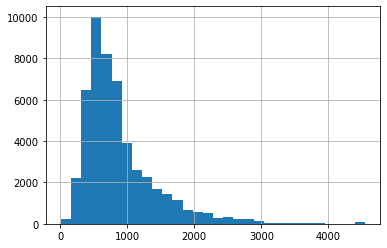

In [13]:
mdLog.mktsz.hist(bins=30)

The market size has a mean of 879.9, median 726.5, standard error of 550.3 and is positively skewed, with min 10 and max 4548.

## Q2
2. Focus on instances in which the mid price changes but the bid-ask spread does not. For an increase (decrease) of the mid price, define the new bid (ask) as the aggressive side, and the other as the defensive side. Report the distribution of the market sizes of the defensive side and aggressive side immediately following a change in mid price. Can you intuitively explain your results?

In [14]:
mdLog = mdLog.assign(mid=(mdLog.ask+mdLog.bid)/2)
mdLog = mdLog.assign(midmove=mdLog.mid.diff())

In [15]:
md_Q2 = mdLog[(mdLog.midmove!=0) & (mdLog.sprdmove==0)]

In [16]:
md_Q2 = md_Q2.assign(bidIsAggr=(md_Q2.midmove>0))

In [17]:
md_Q2 = md_Q2.assign(aggrMktSize=md_Q2.bidsize*md_Q2.bidIsAggr+md_Q2.asksize*(~md_Q2.bidIsAggr))
md_Q2 = md_Q2.assign(defsMktSize=md_Q2.bidsize*(~md_Q2.bidIsAggr)+md_Q2.asksize*md_Q2.bidIsAggr)

In [18]:
md_Q2.head()

,updateCount,lastprice,volume,bidsize,bid,ask,asksize,spread,sprdmove,bidmove,askmove,mktsz,mid,midmove,bidIsAggr,aggrMktSize,defsMktSize
15,16,26.80,789,23,26.79,26.81,72,0.02,0.0,0.01,0.01,47.5,26.800,0.01,True,23,72
361,362,26.75,4742,169,26.74,26.75,116,0.01,0.0,-0.01,-0.01,142.5,26.745,-0.01,False,116,169
390,391,26.75,5307,199,26.75,26.76,393,0.01,0.0,0.01,0.01,296.0,26.755,0.01,True,199,393
400,401,26.75,5442,491,26.74,26.75,49,0.01,0.0,-0.01,-0.01,270.0,26.745,-0.01,False,49,491
414,415,26.75,5561,186,26.75,26.76,433,0.01,0.0,0.01,0.01,309.5,26.755,0.01,True,186,433


In [19]:
md_Q2.aggrMktSize.describe()

count    140.000000
mean     123.135714
std      174.904381
min        1.000000
25%       19.750000
50%       54.000000
75%      145.750000
max      909.000000
Name: aggrMktSize, dtype: float64

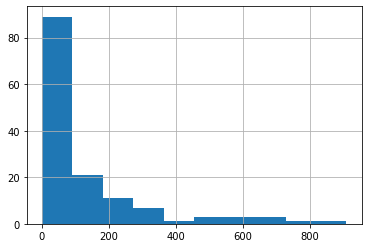

In [20]:
md_Q2.aggrMktSize.hist()

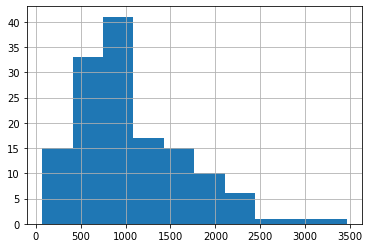

In [21]:
md_Q2.defsMktSize.hist()

In [22]:
md_Q2.defsMktSize.describe()

count     140.000000
mean     1042.642857
std       608.647186
min        72.000000
25%       655.000000
50%       895.000000
75%      1335.750000
max      3461.000000
Name: defsMktSize, dtype: float64

The aggressive market size is on average 123.14 and very concentrated. The average is much smaller than *market size*.

The defensive market size is on average 1042.64 and more spread out. The average is much larger than *market size*.

The intuitive reasoning: when the bid and ask shift, typically few new orders are built on the aggressive side, while the defensive side are hit into the deeper book. So the aggressive market size tends to be small and the defensive market size tends to be large.

## Q3
3. If, from one update to the next, volume increases from 100 to 150, we know 50 was traded between the two updates. Many trades of varying size at various prices could have happened between the two updates; we only know that the most recent trade happened at the lastprice. Come up with a realistic volume allocation method that allocates the traded volume to price levels. Justify the method and append your allocation to mdLog.csv.

Because cancellation and fill might happen many times between updates, the possibility is infinite and the trade allocation can only be inferred. I'm taking an simple way to allocate.

In [23]:
mdLog = mdLog.assign(trdVolume=mdLog.volume.diff())
mdLog = mdLog.assign(bidszchg=mdLog.bidsize.diff())
mdLog = mdLog.assign(askszchg=mdLog.asksize.diff())

In [24]:
mdLog.trdVolume.describe()

count    50233.000000
mean        11.685585
std         55.593706
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max       2451.000000
Name: trdVolume, dtype: float64

In [25]:
mdLog = mdLog.assign(closer2lastbid=abs(mdLog.lastprice-mdLog.bid+mdLog.bidmove)<abs(mdLog.lastprice-mdLog.ask+mdLog.askmove))

In [26]:
mdLog = mdLog.assign(bidBackawayQty=mdLog.bidsize*(mdLog.bidmove<0) + mdLog.bidszchg*(mdLog.bidmove==0))
mdLog = mdLog.assign(askBackawayQty=mdLog.asksize*(mdLog.askmove>0) + mdLog.askszchg*(mdLog.askmove==0))

In [43]:
def allocateTrade(x):
    minTrdQty=1
    lastbid=x.bid-x.bidmove
    lastask=x.ask-x.askmove
    if x.trdVolume==0:
        return {}
    elif x.closer2lastbid:      
        if x.lastprice==lastbid:
                return {lastbid:x.trdVolume}
        elif x.lastprice!=lastbid:
            if x.bidBackawayQty>x.trdVolume:
                return {x.lastprice:minTrdQty,lastbid:x.trdVolume-minTrdQty}
            elif x.bidBackawayQty<=x.trdVolume:
                return {x.lastprice:x.trdVolume-x.bidBackawayQty,lastbid:x.bidBackawayQty}
    elif not x.closer2lastbid:  
        if x.lastprice==lastask:
                return {lastask:x.trdVolume}
        elif x.lastprice!=lastask:
            if x.askBackawayQty>x.trdVolume:
                return {x.lastprice:minTrdQty,lastask:x.trdVolume-minTrdQty}
            elif x.askBackawayQty<=x.trdVolume:
                return {x.lastprice:x.trdVolume-x.askBackawayQty,lastask:x.askBackawayQty}
        

In [44]:
mdLog=mdLog.assign(trdAlloc=mdLog.apply(allocateTrade,axis=1))

In [45]:
mdLog.head()

,updateCount,lastprice,volume,bidsize,bid,ask,asksize,spread,sprdmove,bidmove,...,mktsz,mid,midmove,trdVolume,bidszchg,askszchg,closer2lastbid,bidBackawayQty,askBackawayQty,trdAlloc
0,1,26.78,303,455,26.77,26.79,1,0.02,NaN,NaN,...,228.0,26.780,NaN,NaN,NaN,NaN,False,NaN,NaN,None
1,2,26.78,303,455,26.77,26.79,1,0.02,0.000000e+00,0.00,...,228.0,26.780,0.000,0.0,0.0,0.0,False,0.0,0.0,{}
2,3,26.77,361,518,26.77,26.78,1,0.01,-1.000000e-02,0.00,...,259.5,26.775,-0.005,58.0,63.0,0.0,True,63.0,0.0,{26.77: 58.0}
3,4,26.79,374,42,26.78,26.79,44,0.01,-3.552714e-15,0.01,...,43.0,26.785,0.010,13.0,-476.0,43.0,False,0.0,44.0,"{26.79: 1, 26.78: 12.0}"
4,5,26.79,413,163,26.77,26.80,2,0.03,2.000000e-02,-0.01,...,82.5,26.785,0.000,39.0,121.0,-42.0,False,163.0,2.0,{26.79: 39.0}


## Q4
4. We define sizeDelta as the size added or cancelled on a level from one update to the next, net of any traded volume. For example, on update 1, the bidsize was 100. On update 2, the bid price is unchanged and the bidsize is now 70. Suppose, from part 3, that we believe a total of size 20 was traded at the bid. Then we have sizeDeltaAtBid = -10, as in orders totaling size 10 were canceled between update 1 and update 2 on the bid. Note that sizeDelta is only defined for price levels that are unchanged from the previous update.

Add to mdLog.csv two additional columns: sizeDeltaAtBid and sizeDeltaAtAsk. Report the distribution of these two variables.

In [54]:
def calcSizeDeltaAtBid(x):
    if x.bidmove == 0:
        if x.bid in x.trdAlloc.keys():
            trd_alloc = x.trdAlloc[x.bid]
            return x.bidszchg+trd_alloc
        else:
            return x.bidszchg
    else:
        return None

In [62]:
def calcSizeDeltaAtAsk(x):
    if x.askmove == 0:
        if x.ask in x.trdAlloc.keys():
            trd_alloc = x.trdAlloc[x.ask]
            return x.askszchg+trd_alloc
        else:
            return x.askszchg
    else:
        return None

In [60]:
mdLog = mdLog.assign(sizeDeltaAtBid=mdLog.apply(calcSizeDeltaAtBid,axis=1))

In [63]:
mdLog = mdLog.assign(sizeDeltaAtAsk=mdLog.apply(calcSizeDeltaAtAsk,axis=1))

In [65]:
mdLog.sizeDeltaAtBid.describe()

count    48903.000000
mean         4.822383
std         69.786535
min      -4794.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1598.000000
Name: sizeDeltaAtBid, dtype: float64

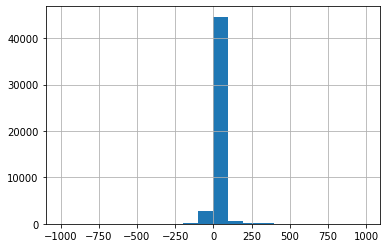

In [71]:
mdLog.sizeDeltaAtBid[abs(mdLog.sizeDeltaAtBid)<1000].hist(bins=20)

In [69]:
mdLog.sizeDeltaAtAsk.describe()

count    48888.000000
mean         4.249366
std         63.428201
min      -2830.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1098.000000
Name: sizeDeltaAtAsk, dtype: float64

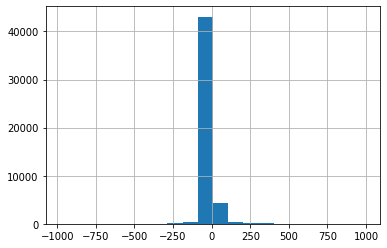

In [72]:
mdLog.sizeDeltaAtAsk[abs(mdLog.sizeDeltaAtAsk)<1000].hist(bins=20)

sizeDeltaAtBid and sizeDeltaAtAsk are mainly concentrated on around 0, slight positive on average. They have very thin tail, which means large moves are rare.

## Q5
5. Now we will focus on the aggressive side. Assume the size on the aggressive side we see immediately after a price change is from a single limit order, which we call the top order. We wish to track the performance of top orders. Assume cancellations always happen from the back of the queue and the order may be partially cancelled.

Note that all top orders are inserted at the BBO (Best Bid Offer), as in a buy (sell) top order is always inserted at the best bid (ask). However, not all top orders spend their entire lifespan on the BBO. Report the total number of top orders, the number that do not spend their entire lifespan on the BBO, and the number that do. Out of those that do spend their entire lifespan on the BBO, how many are filled for their original size?

In [58]:
md_Q2.head()

,updateCount,lastprice,volume,bidsize,bid,ask,asksize,spread,sprdmove,bidmove,askmove,mktsz,mid,midmove,bidIsAggr,aggrMktSize,defsMktSize
15,16,26.80,789,23,26.79,26.81,72,0.02,0.0,0.01,0.01,47.5,26.800,0.01,True,23,72
361,362,26.75,4742,169,26.74,26.75,116,0.01,0.0,-0.01,-0.01,142.5,26.745,-0.01,False,116,169
390,391,26.75,5307,199,26.75,26.76,393,0.01,0.0,0.01,0.01,296.0,26.755,0.01,True,199,393
400,401,26.75,5442,491,26.74,26.75,49,0.01,0.0,-0.01,-0.01,270.0,26.745,-0.01,False,49,491
414,415,26.75,5561,186,26.75,26.76,433,0.01,0.0,0.01,0.01,309.5,26.755,0.01,True,186,433


We have defined "aggressive" in Q2.

In [75]:
md_Q2=md_Q2.assign(isTopOrder=True)

In [77]:
mdLog = mdLog.merge(md_Q2[["updateCount","isTopOrder","bidIsAggr"]],on='updateCount', how='left')

In [ ]:
# mdLog.Effect
for i in range(len(mdLog)):
    entry = mdLog.loc[i]
    BBOMoved = (entry.bidmove<>0) if entry.bidIsAggr else (entry.askmove<>0)
    count=0
    CumTopFillQty=0
    CumCancelledFillQty=0
    TopOrderPx=None
    TopOrderQty=None
    Done=False
    
    if BBOMoved and Done:
        count+=1
    if entry.isTopOrder:
        TopOrderPx = entry.bid if entry.bidIsAggr else entry.ask
        TopOrderQty = entry.bidsize if entry.bidIsAggr else entry.asksize
        CumTopFillQty=0
        CumCancelledFillQty=0
        Done=False
    elif i==0 or (mdLog["TopOrderRemain"][i-1] == None):
        pass
    else:
        trd_alloc = mdLog.trdAlloc[i]
        CumTopCancelledQty += max(TopOrderQty-CumTopFillQty-CumTopFillQty-mdLog.bidsize[i],0)
        CumTopFillQty += trd_alloc[TopOrderPx] if TopOrderPx in trd_alloc.keys() else 0
        if CumTopFillQty+CumTopCancelledQty>=TopOrderQty:
            Done = True
        
 

## Q6
6. We define return as the signed difference between the execution price of an order and the mid price 40 market updates after the time of the final trade. By convention, we normalize these returns by the ticksize, which is 0.01 in this case. Therefore, if a buy order is all traded at 19.20, the bid 40 updates later is 19.20, and the ask 40 updates later is 19.21, then the return is 0.5. Report average returns of top orders that spend their entire lives at the BBO and are completely filled.

## Q7
7. Shift focus to top orders that do not spend their entire lives at the BBO. Report the average returns of these orders. Explicitly state your assumptions regarding your treatment of these orders while they are not at the BBO.

## Q8
8. Focusing on top orders that spend their entire lifespan at the BBO and are completely filled, can you write a model for the return of these orders based on the size of such orders and the sizeDelta variables you see on the second update after the order was inserted? Can you improve your model via other predictors with information taken on or before the second update after the order was inserted?

We can run a linear model with the factors.

For other potential factors, we can take the book imbalance as one.

## Q9
9. What are the pros and cons of using the above definition of returns as a metric for order attractiveness? What are some (potentially better) alternatives?

Pros: it takes into spread gaining if we are passively filled and loss if we aggressively take

Cons: similarly, market impact is messed with this measure.

If we want to measure the market impact , we can use mid to mid return.

## Q10
10. Any other interesting observations you want to point out? What assumptions in the problems struck you as unrealistic or overly simplistic?

The assumption of single limit order of top order may be overly simplistic.